# Telco Customer Churn – Univariate Predictor Challenge

![Churn Analysis](data/churn.png)
### Project Brief

> **Business context** – Reducing voluntary churn is a primary driver of profitability in subscription businesses.  Pinpointing the one factor that most strongly signals attrition helps the retention team focus interventions and craft targeted offers.


### The Dataset


| Attribute | Description |
|-----------|-------------|
| **File** | Telco-Customer-Churn.csv (≈ 7k rows, 21 columns) |
| **Target column** | Churn – "Yes" / "No" |
| **Identifier** | customerID (must be excluded from modelling) |
| **Predictors** | Mixed types: <br>• Demographics (gender, SeniorCitizen, Partner, Dependents)<br>• Services (InternetService, StreamingTV, …)<br>• Contract details (Contract, PaperlessBilling, PaymentMethod)<br>• Usage (tenure, MonthlyCharges, TotalCharges) |
| **Missing data** | TotalCharges contains 11 blank strings → treat as NaN |


### Learning Objectives

1. Practise **feature‑type diagnostics** and appropriate encoding (boolean, numerical, nominal, ordinal).
2. Compute **out‑of‑sample performance** via stratified 5‑fold cross‑validation.
3. Consolidate results into a tidy ranking table and extract the top scorer.


### Task Checklist

| Step | Action | Expected artefact |
|------|--------|-------------------|
| 1 | Load the CSV into a DataFrame named `telco`. | – |
| 2 | Convert `TotalCharges` to numeric, coercing errors to `NaN`, then mean‑impute. | Cleaned `telco` DataFrame |
| 3 | Map `Churn` to binary **0 = "No", 1 = "Yes"**. | `telco['Churn']` as `int` |
| 4 | Drop the `customerID` column. | – |
| 5 | Identify candidate predictors: every remaining column except `Churn`. | Python list `features` |
| 6 | For **each** feature:<br>a. Wrap with `C()` if categorical.<br>b. Fit `logit` on the training fold, predict on the validation fold.<br>c. Record the **AUC** for that fold. | List of dicts `results` |
| 7 | Compute the **mean AUC** over the 5 folds for each feature. | `all_results_df` (feature, auc) |
| 8 | Sort descending, take the top row, rename columns to `best_feature`, `best_auc`, and reset the index. | **`best_feature_df`** |

<br>

## Extension Ideas

* **Regularised Logit** – repeat the exercise with `fit_regularized` and observe whether the leader changes.
* **Alternative Metrics** – compare rankings by accuracy, F1, and Matthews CC.
* **Explainability** – draw a violin/box plot of the champion feature split by churn status to visualise separation.


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [7]:
url = "https://raw.githubusercontent.com/jhlopesalves/data-science-practice-notebook/refs/heads/main/Python/projects/telcom_customer_churn/data/Telco-Customer-Churn.csv"
telcom = pd.read_csv(url, usecols=lambda col: not col.startswith("Unnamed"))
telcom

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [8]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# Define columns for encoding
# binary_cols: columns with two categories (excluding the target 'Churn')
binary_cols = [
    "gender",
    "Partner",
    "Dependents",
    "PhoneService",
    "PaperlessBilling",
]
# ord_cols: columns with a natural order (here, contract duration)
ord_cols = ["Contract"]

# Container to store mappings for each encoder
encoders = {}

# 1) Encode binary columns using LabelEncoder
# This converts each category to an integer (e.g., 'Yes'/'No' → 1/0)
for col in binary_cols:
    le = LabelEncoder()
    telcom[col] = le.fit_transform(telcom[col])
    encoders[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# 2) Encode ordinal columns using OrdinalEncoder
# This assigns ordered integers to each contract type
ord_enc = OrdinalEncoder(
    categories=[["Month-to-month", "One year", "Two year"]], dtype=int
)
telcom[ord_cols] = ord_enc.fit_transform(telcom[ord_cols])
encoders["Contract"] = {cat: i for i, cat in enumerate(ord_enc.categories_[0])}

# Print encoder mappings for reference
print(encoders)

{'gender': {'Female': np.int64(0), 'Male': np.int64(1)}, 'Partner': {'No': np.int64(0), 'Yes': np.int64(1)}, 'Dependents': {'No': np.int64(0), 'Yes': np.int64(1)}, 'PhoneService': {'No': np.int64(0), 'Yes': np.int64(1)}, 'PaperlessBilling': {'No': np.int64(0), 'Yes': np.int64(1)}, 'Contract': {'Month-to-month': 0, 'One year': 1, 'Two year': 2}}


In [9]:
# Create a cleaned version of the telcom DataFrame for modeling
# Drop the customerID column (identifier, not a predictor)
# Convert TotalCharges, tenure, and MonthlyCharges to numeric (coerce errors to NaN)
# Drop rows where TotalCharges is missing (after conversion)
telcom2 = (
    telcom.drop(columns=["customerID"])
    .assign(
        TotalCharges=lambda x: pd.to_numeric(x.TotalCharges, errors="coerce"),
        tenure=lambda x: pd.to_numeric(x.tenure, errors="coerce"),
        MonthlyCharges=lambda x: pd.to_numeric(x.MonthlyCharges, errors="coerce"),
    )
    .dropna(subset=["TotalCharges"])
)

In [10]:
# List of columns that represent binary features (0/1) in telcom2
binary_bool_cols = [
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "PaperlessBilling",
    "PhoneService",
]

# Convert these columns from integer (0/1) to boolean (False/True)
# This makes downstream analysis and modeling more interpretable and consistent
telcom2[binary_bool_cols] = telcom2[binary_bool_cols].astype(bool)

In [11]:
# Define service columns that require special handling for "No phone service" and "No internet service"
service_cols_no_phone = ["MultipleLines"]
service_cols_no_internet = [
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
]

# Build a dictionary of replacements:
# - For MultipleLines, treat "No phone service" as "No"
# - For internet-dependent services, treat "No internet service" as "No"
replacements = {
    "MultipleLines": {"No phone service": "No"},
}
for col in service_cols_no_internet:
    replacements[col] = {"No internet service": "No"}

# Apply replacements to telcom2 DataFrame
telcom2 = telcom2.replace(replacements)

# Combine all service columns for boolean conversion
all_service_cols = service_cols_no_phone + service_cols_no_internet

# Convert "Yes"/"No" strings to boolean: True for "Yes", False otherwise
telcom2[all_service_cols] = telcom2[all_service_cols].apply(lambda col: col == "Yes")

In [12]:
# One-hot encode categorical columns: InternetService, Contract, PaymentMethod
# This creates new boolean columns for each category (except the first, due to drop_first=True)
# The original columns are removed, and new columns like InternetService_Fiber optic, Contract_One year, etc. are added
telcom2 = pd.get_dummies(
    telcom2,
    columns=["InternetService", "PaymentMethod"],
    drop_first=True,
)

In [13]:
# Map the original 'Churn' column from telcom to binary values in telcom2
# "No" becomes 0 (False), "Yes" becomes 1 (True)
# This creates a boolean target column for modeling
telcom2["Churn"] = telcom.Churn.map({"No": 0, "Yes": 1}).astype(bool)

In [14]:
# Split predictors and target variable for modeling
X = telcom2.drop(columns=["Churn"])
y = telcom2["Churn"]

In [15]:
# Split features and target
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

### Logistic Regression Pipeline (Raw)

This pipeline preprocesses the input data by standardising numeric features (`tenure`, `MonthlyCharges`, `TotalCharges`) using `StandardScaler` and leaves all other features unchanged. It then fits a logistic regression classifier with class weights balanced for class imbalance, robust optimisation (`lbfgs`), and high iteration limit for convergence. The pipeline ensures consistent, reproducible preprocessing and model fitting for both training and inference.


In [16]:
# Build a pipeline for logistic regression with numeric feature scaling
# StandardScaler: standardizes numeric columns (mean=0, std=1)
# ColumnTransformer: applies scaling only to numeric_cols, passes other columns unchanged
# LogisticRegression: fits a classifier with balanced class weights and increased max_iter for convergence

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

# Preprocessing: scale numeric columns, passthrough others
prepoc = ColumnTransformer(
    transformers=[("num", StandardScaler(), numeric_cols)],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

# Pipeline: preprocessing + logistic regression
logreg_pipeline = Pipeline(
    steps=[
        ("pre", prepoc),
        (
            "clf",
            LogisticRegression(
                solver="lbfgs",
                max_iter=5000,
                n_jobs=-1,
                class_weight="balanced",
                random_state=42,
            ),
        ),
    ]
)

In [17]:
# Fit the logistic regression pipeline to the training data
logreg_pipeline.fit(X_train, y_train)

# Print the accuracy of the model on the test set
print("Accuracy on test set:", logreg_pipeline.score(X_test, y_test))

Accuracy on test set: 0.7332195676905574


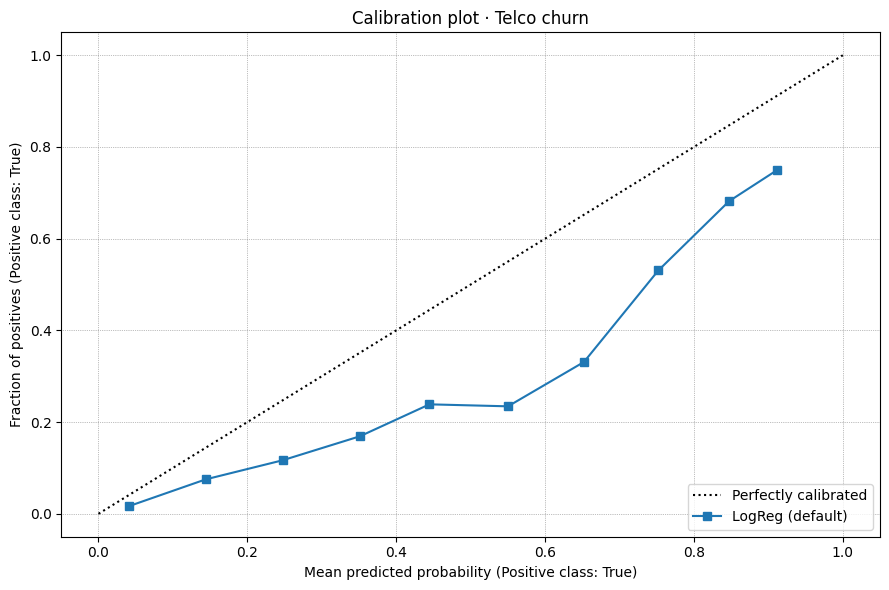

In [18]:
### Diagnostic: calibration of churn probabilities
from sklearn.calibration import CalibrationDisplay

fig, ax = plt.subplots(figsize=(9, 6))

CalibrationDisplay.from_estimator(
    logreg_pipeline,  # use your fitted Pipeline
    X_test,
    y_test,
    n_bins=10,
    ax=ax,
    name="LogReg (default)",
)

ax.set_title("Calibration plot · Telco churn")
ax.grid(True, color="grey", ls=":", lw=0.5)
fig.tight_layout()
plt.show()

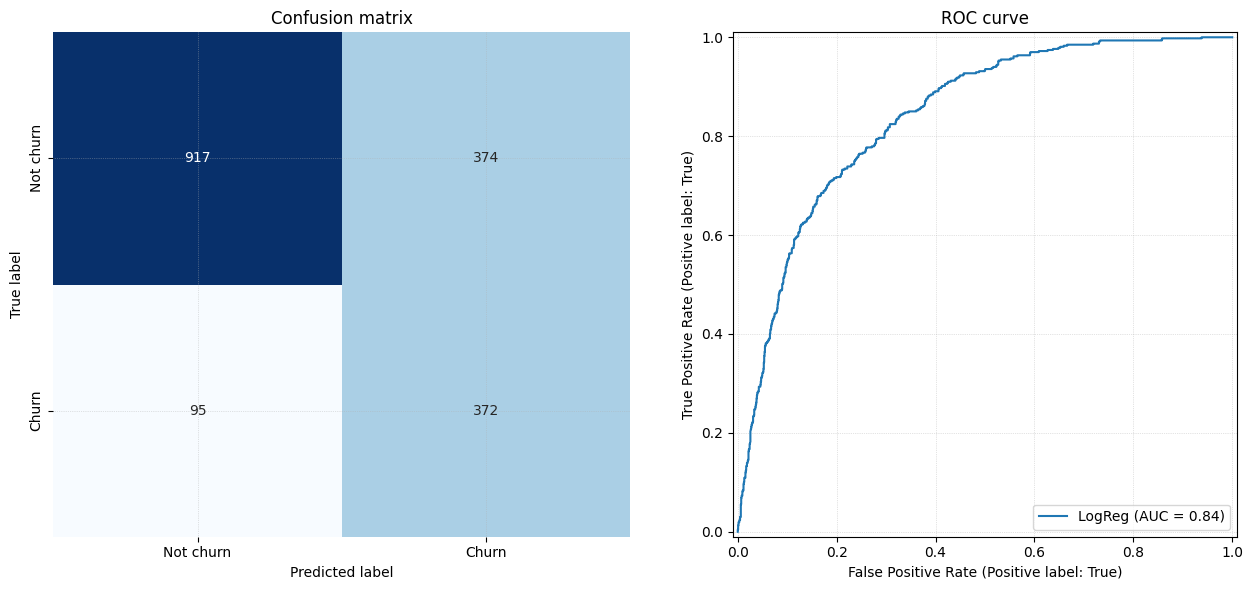

In [19]:
from sklearn.metrics import RocCurveDisplay, confusion_matrix

# Create a figure with two subplots: one for the confusion matrix, one for the ROC curve
fig, (ax_cm, ax_roc) = plt.subplots(1, 2, figsize=(13, 6))

# Confusion matrix using seaborn heatmap
cm = confusion_matrix(y_test, logreg_pipeline.predict(X_test))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    ax=ax_cm,
    xticklabels=["Not churn", "Churn"],
    yticklabels=["Not churn", "Churn"],
)
ax_cm.set_xlabel("Predicted label")
ax_cm.set_ylabel("True label")
ax_cm.set_title("Confusion matrix")

# ROC curve using sklearn's RocCurveDisplay (seaborn does not provide ROC plotting)
RocCurveDisplay.from_estimator(
    logreg_pipeline, X_test, y_test, ax=ax_roc, name="LogReg"
)
ax_roc.set_title("ROC curve")

for ax in (ax_cm, ax_roc):
    ax.grid(ls=":", lw=0.5, alpha=0.7)

fig.tight_layout()
plt.show()

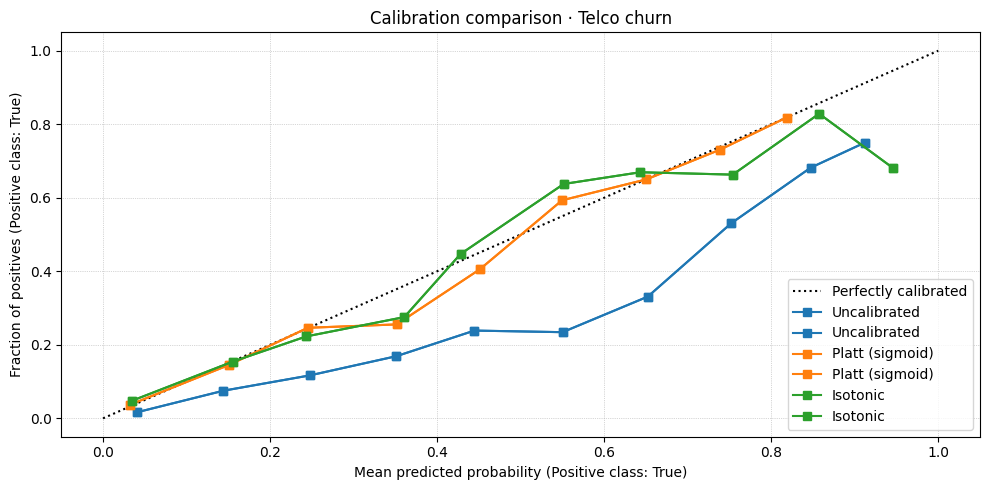

In [20]:
# Probability calibration comparison for logistic regression
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression

# Create a base logistic regression model with increased max_iter for convergence
base_lr = LogisticRegression(max_iter=5000)

# Wrap base_lr with Platt scaling (sigmoid) and isotonic calibration
platt = CalibratedClassifierCV(estimator=base_lr, method="sigmoid", cv=5)
iso = CalibratedClassifierCV(estimator=base_lr, method="isotonic", cv=5)

# Fit both calibrated models on the training data
platt.fit(X_train, y_train)
iso.fit(X_train, y_train)

# Create a figure for calibration plots
fig, ax = plt.subplots(figsize=(10, 5))

# Plot calibration curve for the uncalibrated pipeline
cal_disp = CalibrationDisplay.from_estimator(
    logreg_pipeline, X_test, y_test, n_bins=10, name="Uncalibrated", ax=ax
)
cal_disp.plot(ax=ax, name="Uncalibrated", color=sns.color_palette()[0])

# Plot calibration curve for Platt (sigmoid) calibrated model
cal_disp_platt = CalibrationDisplay.from_estimator(
    platt, X_test, y_test, n_bins=10, name="Platt (sigmoid)", ax=ax
)
cal_disp_platt.plot(ax=ax, name="Platt (sigmoid)", color=sns.color_palette()[1])

# Plot calibration curve for isotonic calibrated model
cal_disp_iso = CalibrationDisplay.from_estimator(
    iso, X_test, y_test, n_bins=10, name="Isotonic", ax=ax
)
cal_disp_iso.plot(ax=ax, name="Isotonic", color=sns.color_palette()[2])

# Set plot title and grid for better readability
ax.set_title("Calibration comparison · Telco churn")
ax.grid(ls=":", lw=0.5)
fig.tight_layout()
plt.show()

### Platt-Calibrated Logistic Regression Pipeline

This pipeline wraps the entire logistic regression pipeline in a probability calibration step using `CalibratedClassifierCV` with Platt scaling (`method="sigmoid"`). The calibrator uses 5-fold cross-validation to adjust the raw model’s output probabilities, making them more reliable as true probability estimates. This is essential when probability calibration is critical for business decisions, risk scoring, or threshold tuning.


In [21]:
from sklearn.calibration import CalibratedClassifierCV

# Wrap the existing logistic regression pipeline with Platt scaling (sigmoid calibration)
# This improves probability calibration by fitting a sigmoid to the predicted probabilities
platt_pipeline = CalibratedClassifierCV(
    estimator=logreg_pipeline,  # use the fitted pipeline as base estimator
    method="sigmoid",  # Platt scaling
    cv=5,  # 5-fold cross-validation for calibration
)

# Fit the calibrated pipeline on the training data
platt_pipeline.fit(X_train, y_train)

# Print the accuracy of the calibrated model on the test set
print("Accuracy on test set (Calibrated):", platt_pipeline.score(X_test, y_test))

Accuracy on test set (Calibrated): 0.8031854379977247


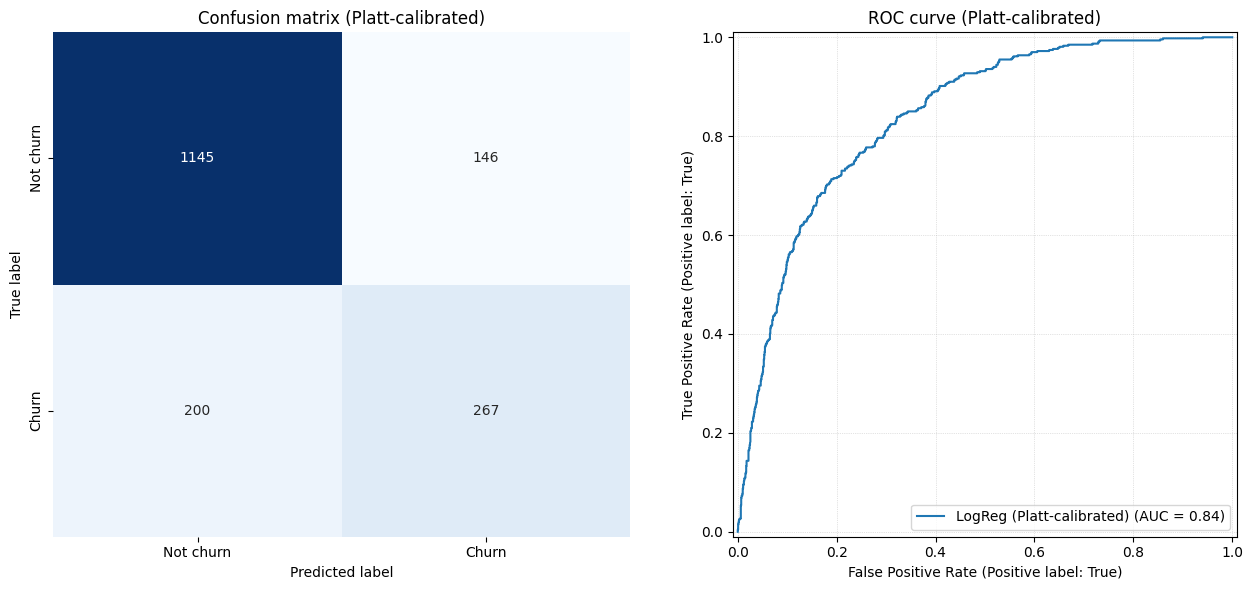

In [22]:
from sklearn.metrics import RocCurveDisplay, confusion_matrix

# Create a figure with two subplots: one for the confusion matrix, one for the ROC curve
fig, (ax_cm, ax_roc) = plt.subplots(1, 2, figsize=(13, 6))

# Compute the confusion matrix for Platt-calibrated predictions on the test set
# This shows the counts of true positives, true negatives, false positives, and false negatives
cm = confusion_matrix(y_test, platt_pipeline.predict(X_test))

# Plot the confusion matrix using seaborn heatmap for better visualization
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    ax=ax_cm,
    xticklabels=["Not churn", "Churn"],
    yticklabels=["Not churn", "Churn"],
)
ax_cm.set(
    xlabel="Predicted label",
    ylabel="True label",
    title="Confusion matrix (Platt-calibrated)",
)
# Plot the ROC curve for the Platt-calibrated pipeline
# This shows the trade-off between true positive rate and false positive rate
RocCurveDisplay.from_estimator(
    platt_pipeline, X_test, y_test, ax=ax_roc, name="LogReg (Platt-calibrated)"
)
ax_roc.set(title="ROC curve (Platt-calibrated)")
ax_roc.grid(ls=":", lw=0.5, alpha=0.7)

fig.tight_layout()
plt.show()

In [23]:
# Get predicted probabilities for the positive class:
probs_platt = platt_pipeline.predict_proba(X_test)[:, 1]

In [24]:
from sklearn.metrics import precision_recall_fscore_support

# Define a range of thresholds from 0 to 1 (step 0.01)
thresholds = np.arange(0, 1.01, 0.01)
recalls, precisions, f1s = [], [], []

# For each threshold, compute precision, recall, and F1 score
for t in thresholds:
    # Convert predicted probabilities to binary predictions at threshold t
    preds = probs_platt >= t
    # Calculate precision, recall, and F1 for current threshold
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, preds, pos_label=True, average="binary", zero_division=0
    )
    # Store results for plotting/analysis
    recalls.append(recall)
    precisions.append(precision)
    f1s.append(f1)

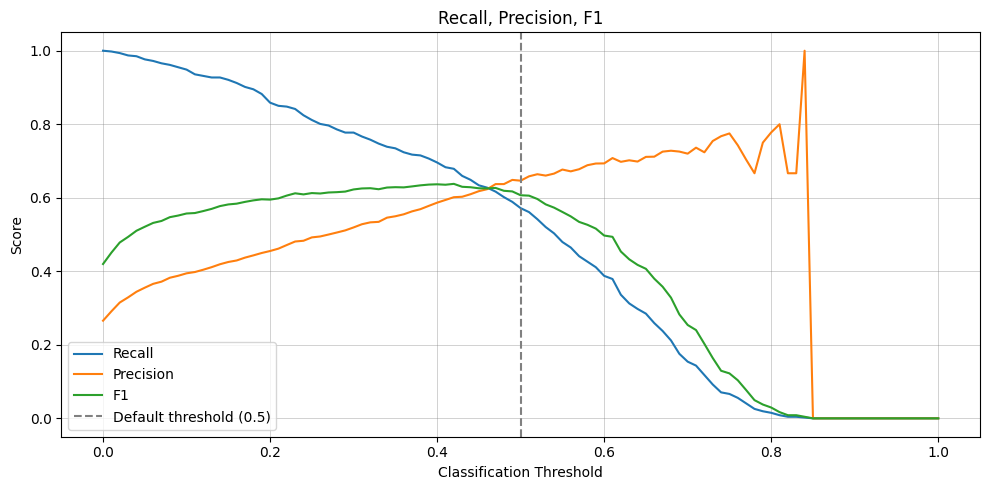

In [25]:
# Plot recall, precision, and F1 score as a function of classification threshold
fig, ax = plt.subplots(figsize=(10, 5))

# Plot recall curve
sns.lineplot(x=thresholds, y=recalls, ax=ax, label="Recall")
# Plot precision curve
sns.lineplot(x=thresholds, y=precisions, ax=ax, label="Precision")
# Plot F1 score curve
sns.lineplot(x=thresholds, y=f1s, ax=ax, label="F1")

# Add a vertical line for the default threshold (0.5)
ax.axvline(0.5, color="grey", ls="--", label="Default threshold (0.5)")

# Set axis labels and title
ax.set(xlabel="Classification Threshold", ylabel="Score", title="Recall, Precision, F1")

# Show legend
ax.legend()

# Improve grid visibility and plot aesthetics
ax.grid(True, alpha=0.5, linewidth=0.5, color="grey")
ax.set_axisbelow(True)

fig.tight_layout()
plt.show()

### Custom-Threshold Prediction Pipeline

This workflow augments the calibrated pipeline by applying a user-defined probability threshold (rather than the default 0.5) to classify churn. The threshold can be tuned for specific business objectives (e.g., maximising recall, precision, or F1-score).  
Unlike earlier pipelines, the custom threshold step is *not* part of the scikit-learn pipeline object itself, but is implemented as a post-processing function—using the calibrated pipeline’s `.predict_proba()` output to generate binary predictions according to the chosen threshold.


In [26]:
# Find the best F1 score and its corresponding threshold
best_f1 = max(f1s)
best_threshold = thresholds[np.argmax(f1s)]  # Threshold at which F1 is maximized

print(f"Best F1: {best_f1:.3f} at threshold {best_threshold:.2f}")

Best F1: 0.638 at threshold 0.42


In [27]:
# Generate predicted probabilities from your calibrated pipeline
probs = platt_pipeline.predict_proba(X_test)[:, 1]

# Apply the chosen threshold (e.g., 0.42) to generate custom class predictions
chosen_threshold = 0.42
y_pred_custom = probs >= chosen_threshold

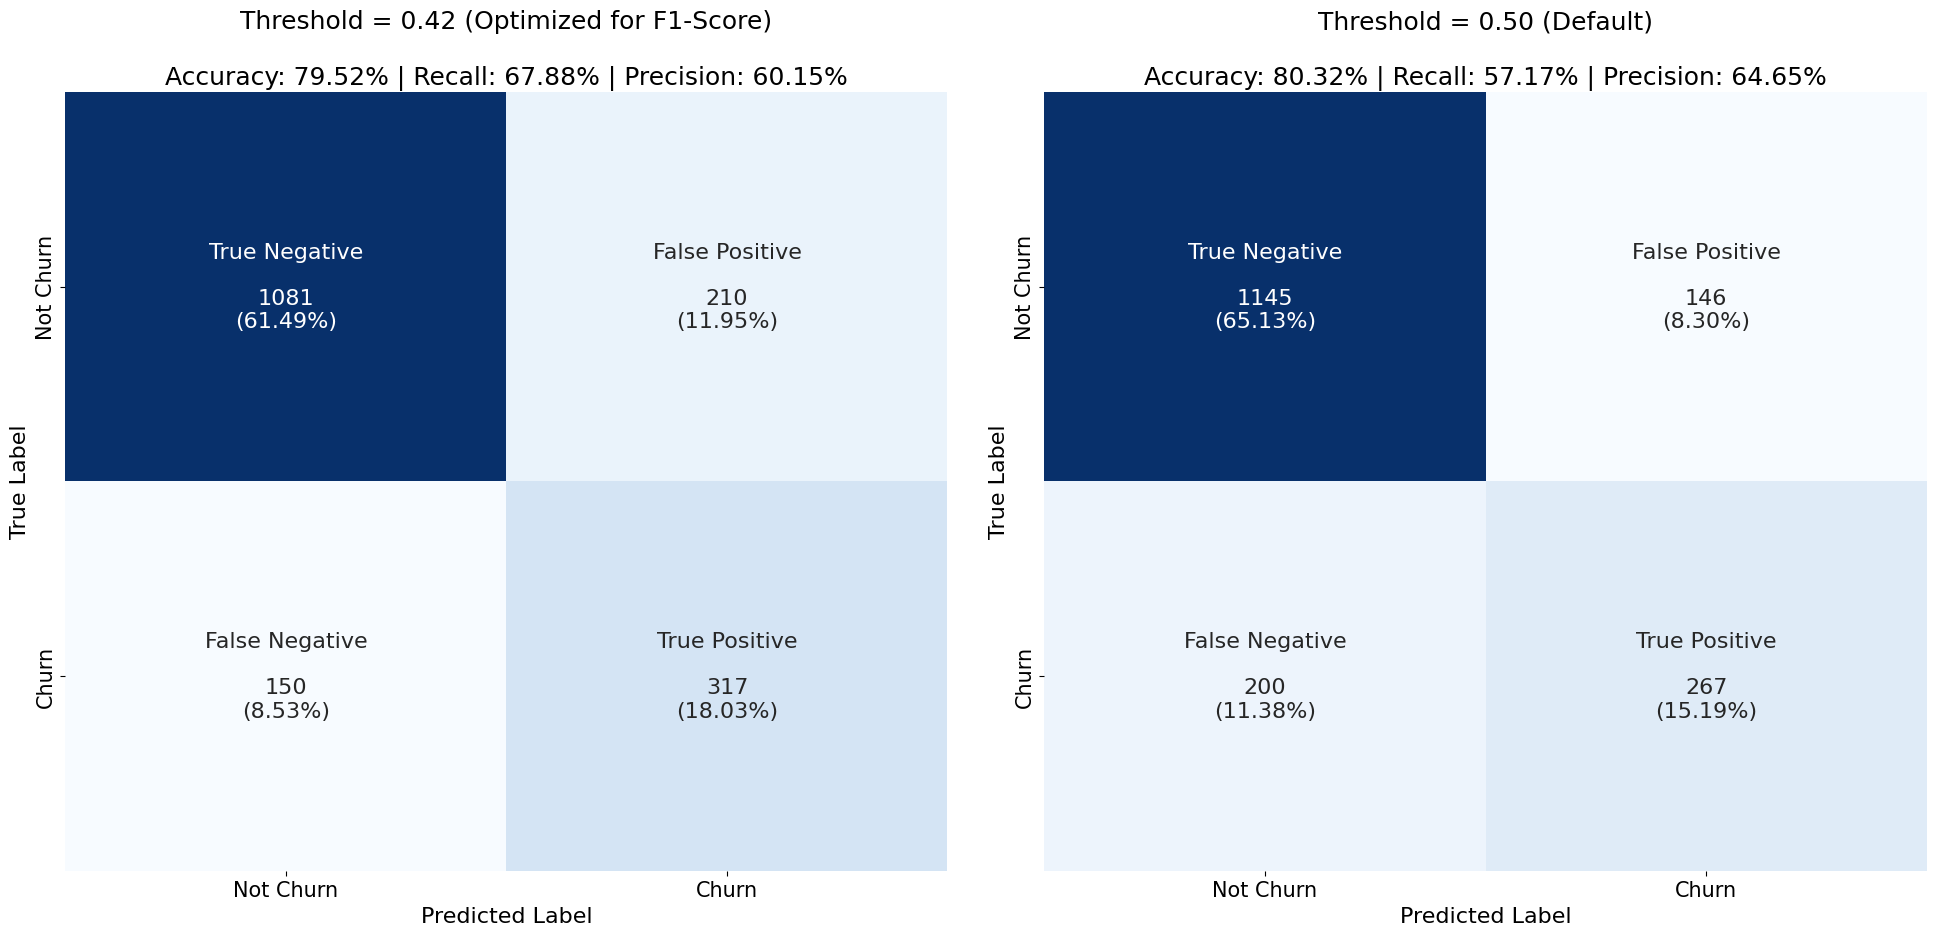

In [28]:
from data.plot_cm_comparison import plot_confusion_matrices
from sklearn.metrics import confusion_matrix

# Compute confusion matrices for two thresholds:
# - 0.42: the threshold that maximizes F1-score (custom, business-optimized)
# - 0.50: the default threshold for binary classification
cm1 = confusion_matrix(y_test, probs_platt >= 0.42)
cm2 = confusion_matrix(y_test, probs_platt >= 0.50)


# Prepare data for plotting: each tuple contains (confusion matrix, subplot title)
plot_data = [
    (cm1, "Threshold = 0.42 (Optimized for F1-Score)"),
    (cm2, "Threshold = 0.50 (Default)"),
]

class_labels = ["Not Churn", "Churn"]
plot_confusion_matrices(plot_data, class_labels)

### Random Forest Pipeline for Churn Prediction

This pipeline applies a `ColumnTransformer` to preprocess the data by one-hot encoding all categorical features and (optionally) standardising numeric features (`tenure`, `MonthlyCharges`, `TotalCharges`) for comparability.  
A `RandomForestClassifier` is then trained on the transformed data. The random forest, as an ensemble of decision trees, naturally captures complex non-linear interactions and is robust to collinearity, scaling, and outliers. Class weights are balanced to address target class imbalance. All preprocessing and modelling steps are encapsulated for reproducibility and direct comparison with other pipelines.


In [29]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Identifies Columns
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
cat_cols = [col for col in X.columns if col not in num_cols]

# Preprocessing transformer
preproc_rf = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        # scaling numeric columns optional for RF, but harmless
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# Random Forest model
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_leaf=5,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
)

# Pipeline
rf_pipeline = Pipeline([("prep", preproc_rf), ("clf", rf)])

# Fit model
rf_pipeline.fit(X_train, y_train)

# 6. Evaluate: probabilities, predictions, metrics as before
rf_probs = rf_pipeline.predict_proba(X_test)[:, 1]
rf_preds = rf_pipeline.predict(X_test)

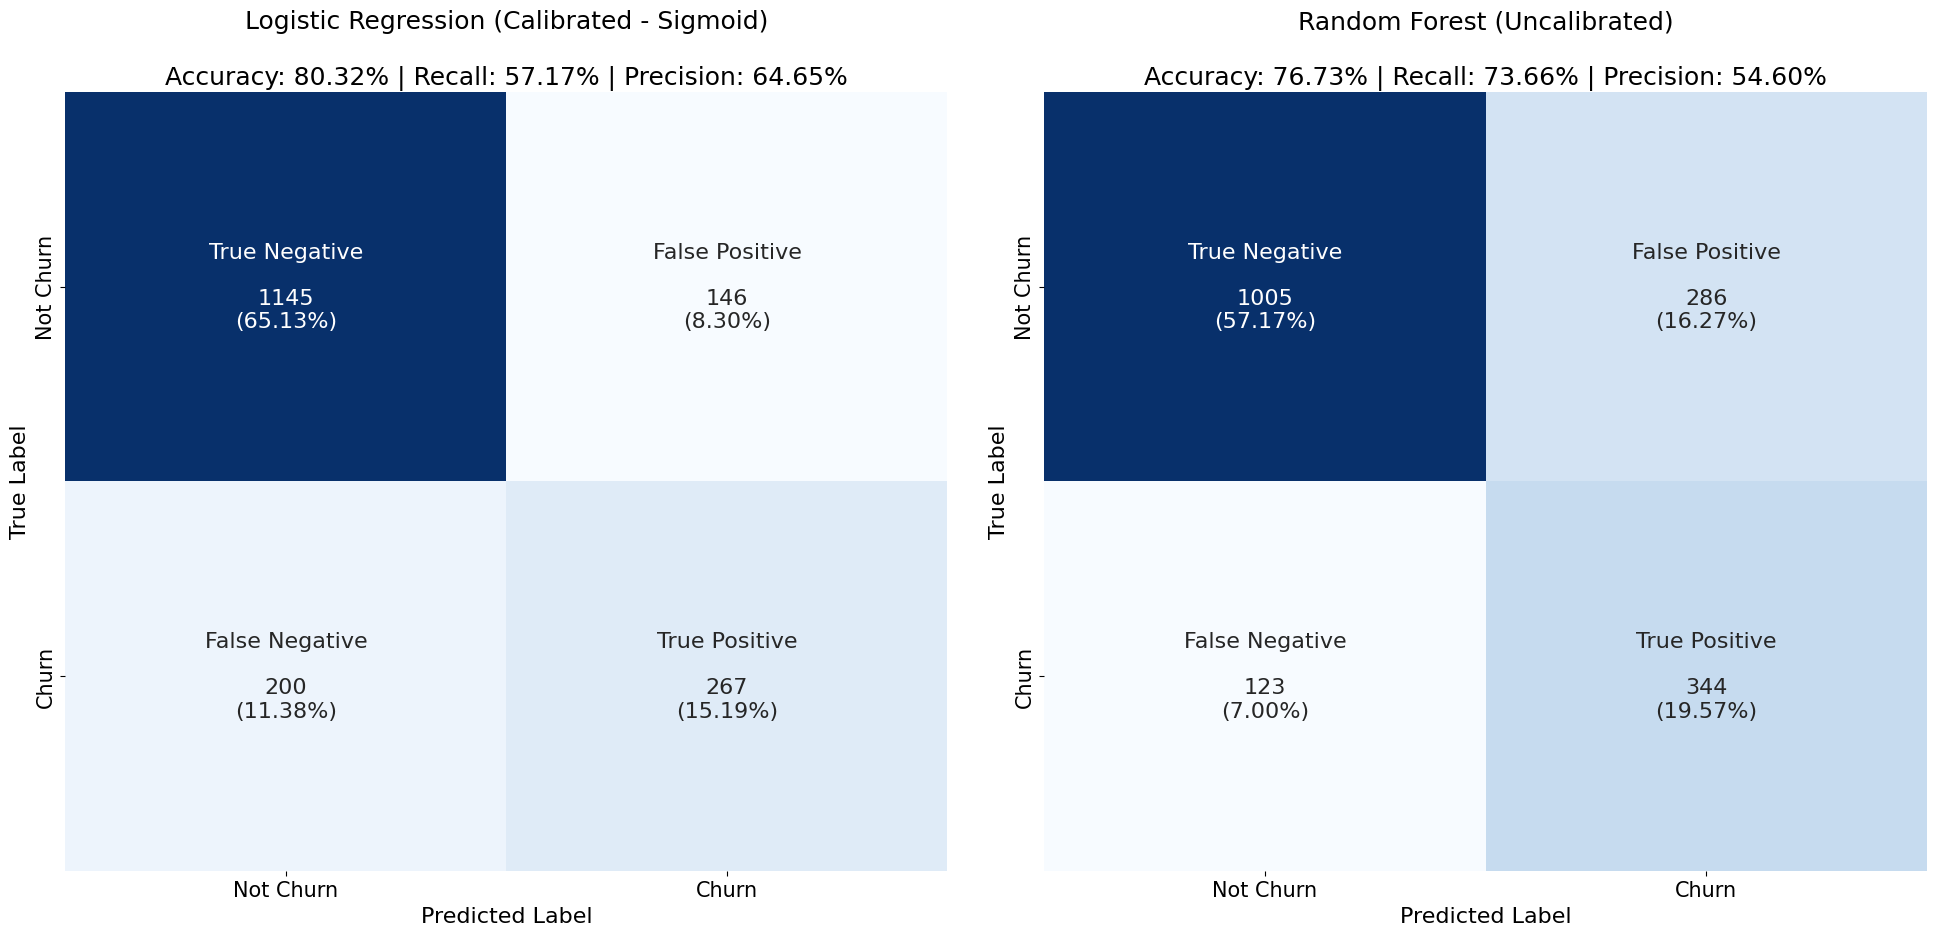

In [30]:
from data.plot_cm_comparison import plot_confusion_matrices
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test, platt_pipeline.predict(X_test))
cm2 = confusion_matrix(y_test, rf_pipeline.predict(X_test))

# Prepare data for plotting: each tuple contains (confusion matrix, subplot title)
plot_data = [
    (cm1, "Logistic Regression (Calibrated - Sigmoid)"),
    (cm2, "Random Forest (Uncalibrated)"),
]

titles = ["Not Churn", "Churn"]
plot_confusion_matrices(plot_data, titles)

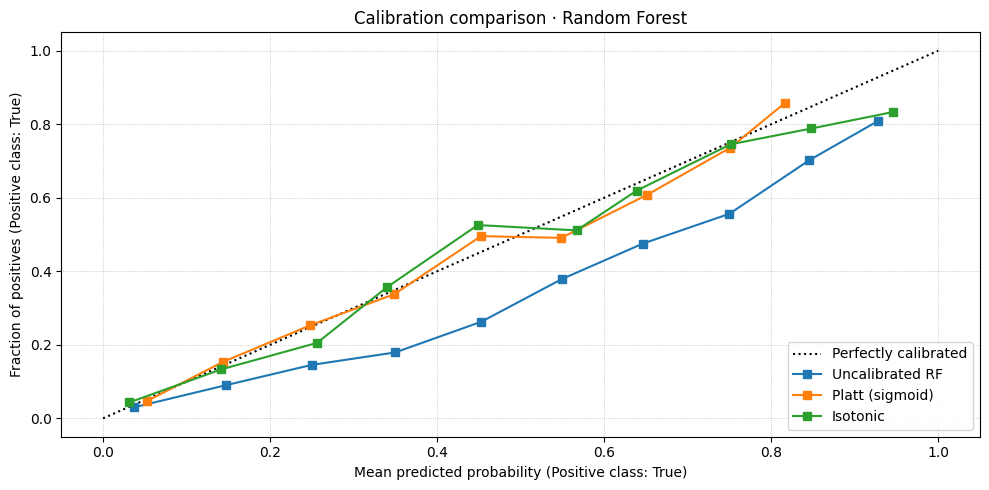

In [31]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# 1. Fit the original, uncalibrated Random Forest pipeline
rf_pipeline.fit(X_train, y_train)

# 2. Create and fit calibrated versions of the RF pipeline
platt_rf = CalibratedClassifierCV(rf_pipeline, method="sigmoid", cv=5)
platt_rf.fit(X_train, y_train)

iso_rf = CalibratedClassifierCV(rf_pipeline, method="isotonic", cv=5)
iso_rf.fit(X_train, y_train)


# 3. Plot the calibration comparison
fig, ax = plt.subplots(figsize=(10, 5))

# Plot for the uncalibrated Random Forest
display_uncalibrated = CalibrationDisplay.from_estimator(
    rf_pipeline, X_test, y_test, n_bins=10, name="Uncalibrated RF", ax=ax
)

# Plot for the Platt (sigmoid) calibrated model
display_platt = CalibrationDisplay.from_estimator(
    platt_rf, X_test, y_test, n_bins=10, name="Platt (sigmoid)", ax=ax
)

# Plot for the isotonic calibrated model
display_iso = CalibrationDisplay.from_estimator(
    iso_rf, X_test, y_test, n_bins=10, name="Isotonic", ax=ax
)

# Set title and grid
ax.set_title("Calibration comparison · Random Forest")
ax.grid(ls=":", lw=0.5)
fig.tight_layout()
plt.show()

In [32]:
from sklearn.calibration import CalibratedClassifierCV

# Wrap the existing random forest pipeline with Platt scaling (sigmoid calibration)
# This improves probability calibration by fitting a sigmoid to the predicted probabilities of the random forest
rf_plat_pipeline = CalibratedClassifierCV(
    estimator=rf_pipeline,  # use the fitted random forest pipeline as base estimator
    method="sigmoid",  # Platt scaling
    cv=5,  # 5-fold cross-validation for calibration
)

# Fit the calibrated pipeline on the training data
rf_plat_pipeline.fit(X_train, y_train)

# Print the accuracy of the calibrated random forest model on the test set
print("Accuracy on test set (Calibrated):", rf_plat_pipeline.score(X_test, y_test))

Accuracy on test set (Calibrated): 0.7935153583617748


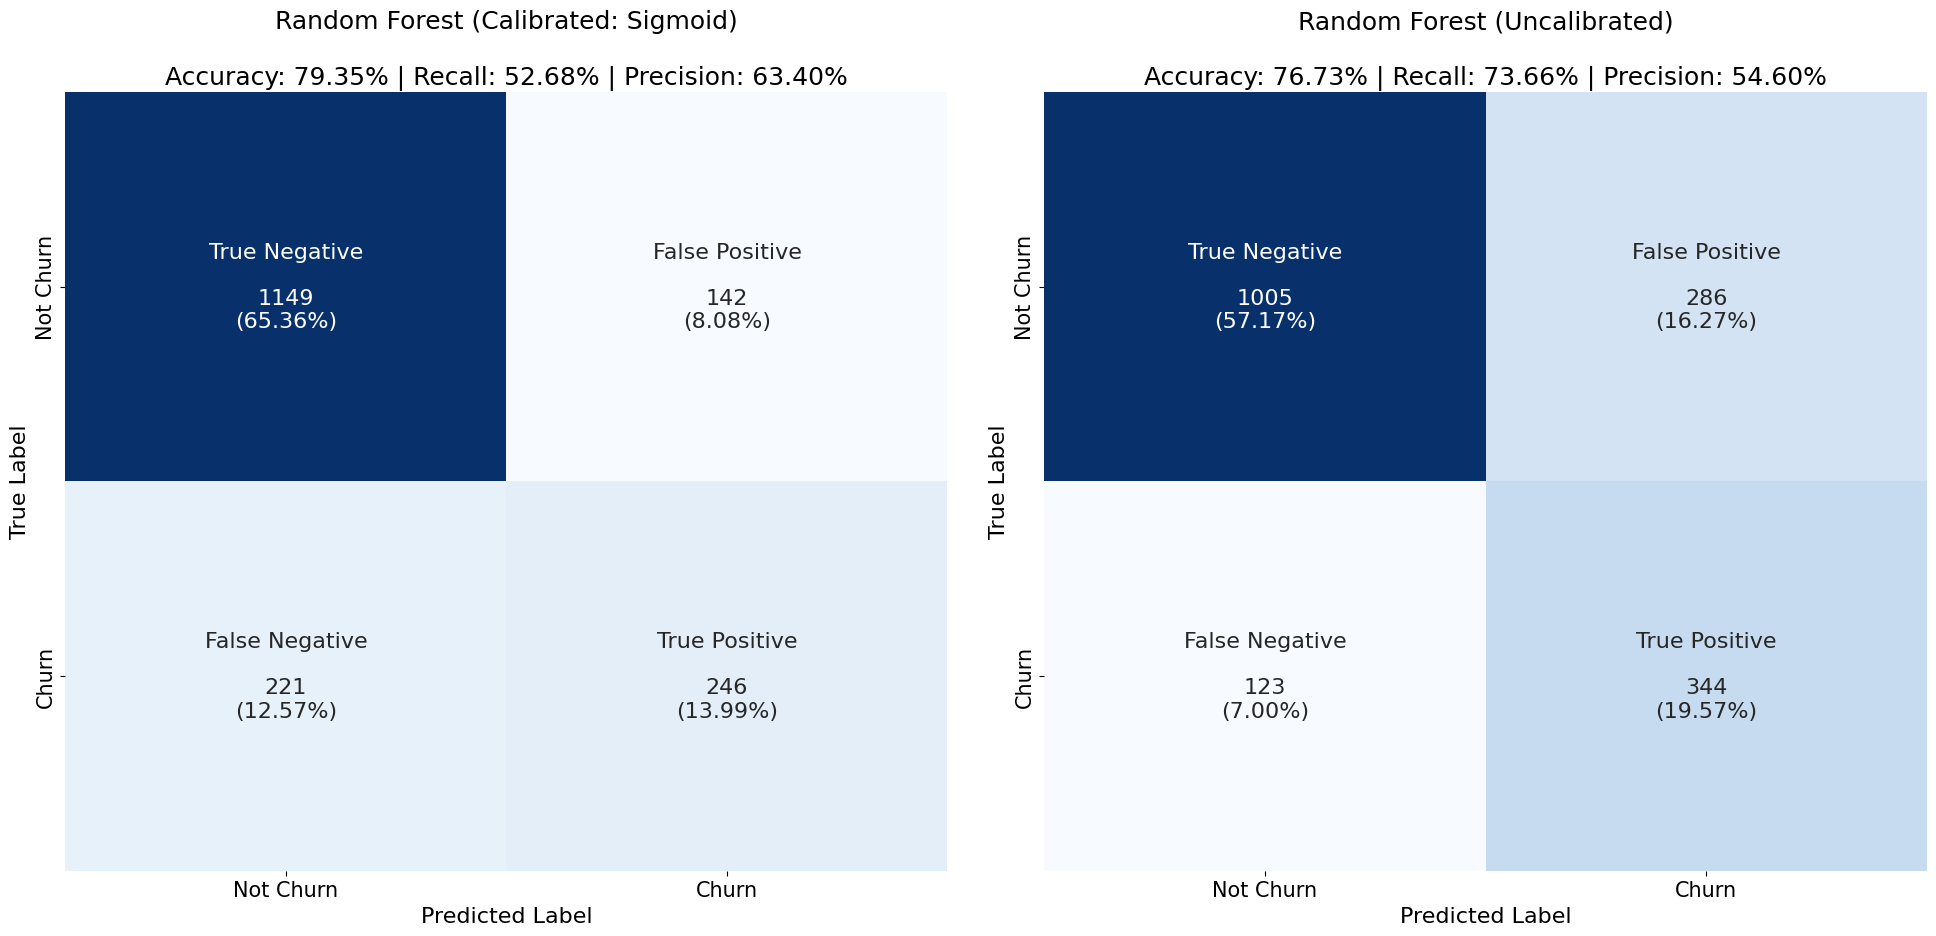

In [33]:
from data.plot_cm_comparison import plot_confusion_matrices
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test, rf_plat_pipeline.predict(X_test))
cm2 = confusion_matrix(y_test, rf_pipeline.predict(X_test))

# Titles for your plots
title_1 = "Random Forest (Calibrated: Sigmoid)"
title_2 = "Random Forest (Uncalibrated)"

# Labels for your classes (0 and 1)
class_labels = ["Not Churn", "Churn"]

# Define the data and labels for the loop
plot_data = [(cm1, title_1), (cm2, title_2)]
group_names = ["True Negative", "False Positive", "False Negative", "True Positive"]

# Loop through and plot each matrix
plot_confusion_matrices(plot_data, class_labels)

In [34]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# initialize models
LR = LogisticRegression(max_iter=5000)
GBC = GradientBoostingClassifier()
RFC = RandomForestClassifier()

# iterate over models, training and evaluating each
for model in [LR, GBC, RFC]:
    model.fit(X_train, y_train)
    scr = model.score(X_test, y_test)  # accuracy score
    print("MODEL:", model.__class__.__name__)
    print("Accuracy on test set:", scr)
    print("-------------")

MODEL: LogisticRegression
Accuracy on test set: 0.8060295790671217
-------------
MODEL: GradientBoostingClassifier
Accuracy on test set: 0.7957906712172924
-------------
MODEL: RandomForestClassifier
Accuracy on test set: 0.7906712172923777
-------------


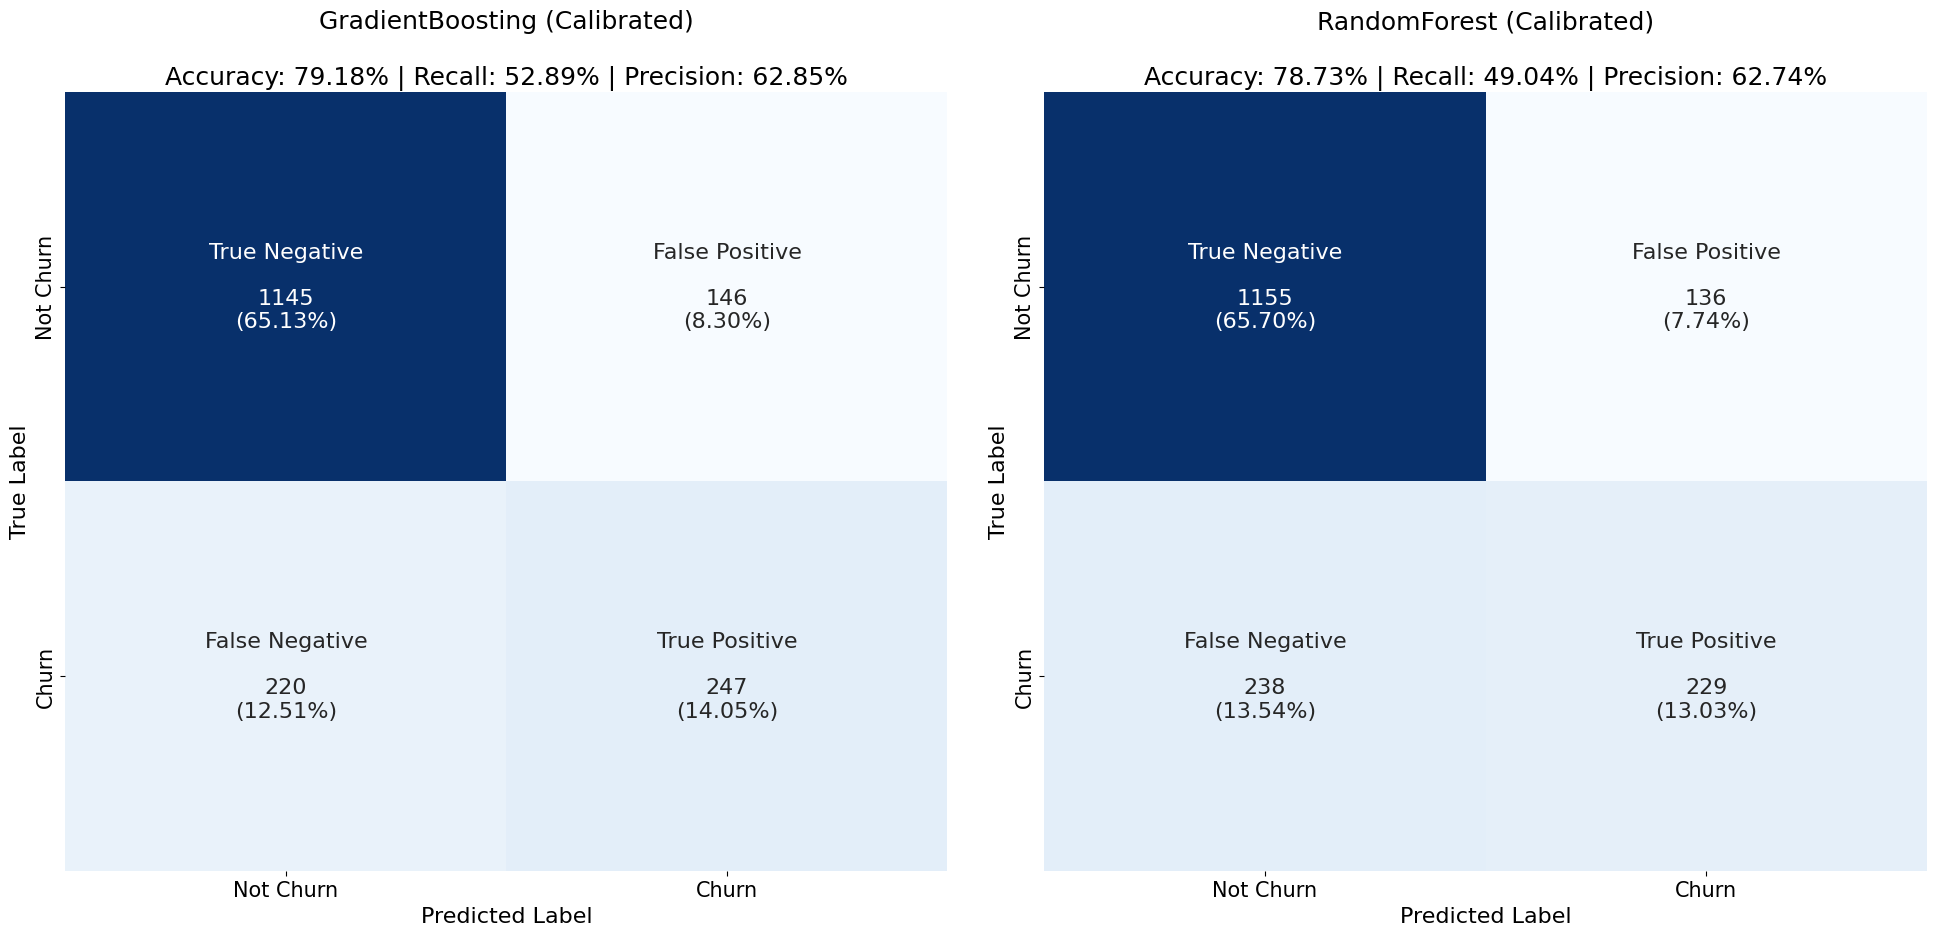

In [35]:
from data.plot_cm_comparison import plot_confusion_matrices
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Instantiate GradientBoosting and RandomForest classifiers with specified hyperparameters
GBR = GradientBoostingClassifier(n_estimators=400, learning_rate=0.05, random_state=42)
RFC = RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42)

# Fit both models on the training data
gbr_fitted = GBR.fit(X_train, y_train)
rfc_fitted = RFC.fit(X_train, y_train)

# Generate confusion matrices for each model's predictions on the test set
cm1 = confusion_matrix(y_test, gbr_fitted.predict(X_test))
cm2 = confusion_matrix(y_test, rfc_fitted.predict(X_test))

# Titles for the confusion matrix plots
title_1 = "GradientBoosting (Calibrated)"
title_2 = "RandomForest (Calibrated)"

# Class labels for the axes of the confusion matrices
class_labels = ["Not Churn", "Churn"]

# Prepare data for plotting: each tuple contains (confusion matrix, subplot title)
plot_data = [(cm1, title_1), (cm2, title_2)]
group_names = ["True Negative", "False Positive", "False Negative", "True Positive"]

# Plot the confusion matrices side by side for comparison
plot_confusion_matrices(plot_data, class_labels)

In [37]:
from tensorflow import keras
from tensorflow.keras import layers

in_dim = X_train.shape[1]

nn_tf = keras.Sequential(
    [
        layers.Input(shape=(in_dim,)),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

nn_tf.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
nn_tf.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6879 - loss: 4.2246 - val_accuracy: 0.7867 - val_loss: 0.5158
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7663 - loss: 0.6535 - val_accuracy: 0.7867 - val_loss: 0.6280
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7643 - loss: 0.6494 - val_accuracy: 0.7820 - val_loss: 0.5714
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7720 - loss: 0.6217 - val_accuracy: 0.7896 - val_loss: 0.6218
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7753 - loss: 0.5529 - val_accuracy: 0.5109 - val_loss: 1.6849
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7330 - loss: 1.1668 - val_accuracy: 0.7867 - val_loss: 1.0645
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7698 - loss: 0.6546 - val_accuracy: 0.7981 - val_loss: 0.5133
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7723 - loss: 0.5375 - val_accuracy: 0.